In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CONFIRMED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/10-28-2020.csv'
df = pd.read_csv(CONFIRMED_URL)
df.head()

#print(df)

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2020-10-29 04:24:49,33.93911,67.709953,41145,1529.0,34237,5379.0,Afghanistan,105.694204,3.716126
1,NaN,NaN,NaN,Albania,2020-10-29 04:24:49,41.15330,20.168300,20040,493.0,10893,8654.0,Albania,696.365279,2.460080
2,NaN,NaN,NaN,Algeria,2020-10-29 04:24:49,28.03390,1.659600,57026,1941.0,39635,15450.0,Algeria,130.044797,3.403711
3,NaN,NaN,NaN,Andorra,2020-10-29 04:24:49,42.50630,1.521800,4517,72.0,3144,1301.0,Andorra,5846.114023,1.593978
4,NaN,NaN,NaN,Angola,2020-10-29 04:24:49,-11.20270,17.873900,10074,275.0,3693,6106.0,Angola,30.651487,2.729799


In [7]:
col_list = ["Country_Region","Confirmed","Deaths","Recovered","Active","Incidence_Rate", "Case-Fatality_Ratio"]
print(df[col_list])

          Country_Region  Confirmed  ...  Incidence_Rate  Case-Fatality_Ratio
0            Afghanistan      41145  ...      105.694204             3.716126
1                Albania      20040  ...      696.365279             2.460080
2                Algeria      57026  ...      130.044797             3.403711
3                Andorra       4517  ...     5846.114023             1.593978
4                 Angola      10074  ...       30.651487             2.729799
...                  ...        ...  ...             ...                  ...
3954  West Bank and Gaza      51948  ...     1018.305506             0.895126
3955      Western Sahara         10  ...        1.674116            10.000000
3956               Yemen       2061  ...        6.910086            29.063561
3957              Zambia      16285  ...       88.582675             2.136936
3958            Zimbabwe       8320  ...       55.978207             2.908654

[3959 rows x 7 columns]


         Date  Confirmed  deaths
0     1/25/20          0       0
1     1/26/20          0       0
2     1/27/20          1       0
3     1/28/20          4       0
4     1/29/20          4       0
..        ...        ...     ...
276  10/27/20     463419   10121
277  10/28/20     486972   10259
278  10/29/20     498354   10305
279  10/30/20     517736   10391
280  10/31/20     531790   10483

[281 rows x 3 columns]


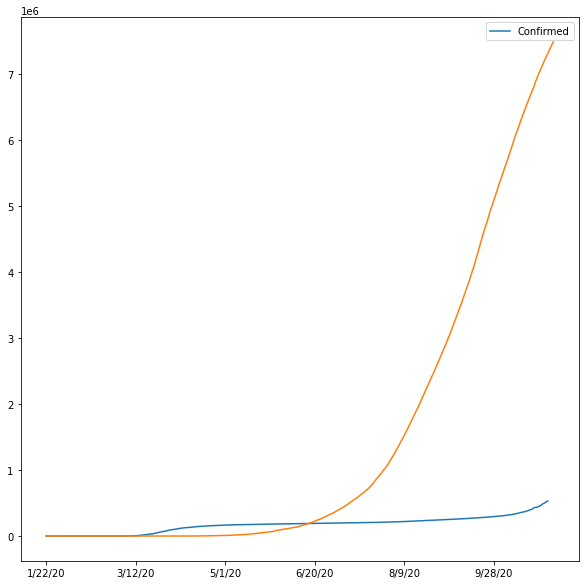

In [8]:
class Corona:


    def __init__(self):

        BASE_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'

        self.URLS = {'confirmed': f'{BASE_URL}/time_series_covid19_confirmed_global.csv',
                'deaths': f'{BASE_URL}/time_series_covid19_deaths_global.csv',
                'recovered':f'{BASE_URL}/time_series_covid19_recovered_global.csv', 
        }


        self.data = {case:pd.read_csv(url) for case, url in self.URLS.items()}
    def current_status(self):
        pass 

corona = Corona()

confirmed_df = corona.data['confirmed']
confirmed_df.to_csv('confirmed.csv', index=False)
#col_list1_item = confirmed_df.next()
#col_list1 = list(col_list1_item)
#print(col_list1_item)
#print(confirmed_df.iloc[:,1:])
#confirmed_df.drop(["Lat","Long"],axis = 1)
confirmed_df_new = (confirmed_df.drop(["Lat","Long","Country/Region"],axis = 1)).iloc[:,4:]
confirmed_df_LK = confirmed_df_new.iloc[130]
#print(type(confirmed_df_LK))
confirmed_df_LK = pd.DataFrame(confirmed_df_LK).reset_index()
confirmed_df_LK.columns = ['Date', 'Confirmed']
#print(confirmed_df_LK)
#confirmed_df_LK = confirmed_df_LK.astype(float)

deaths_df = corona.data['deaths']
deaths_df.to_csv('deaths.csv', index=False)
#col_list1_item = confirmed_df.next()
#col_list1 = list(col_list1_item)
#print(col_list1_item)
#print(confirmed_df.iloc[:,1:])
#confirmed_df.drop(["Lat","Long"],axis = 1)
deaths_df_new = (deaths_df.drop(["Lat","Long","Country/Region"],axis = 1)).iloc[:,4:]
deaths_df_LK = deaths_df_new.iloc[130]
deaths_df_LK = pd.DataFrame(deaths_df_LK).reset_index()
deaths_df_LK.columns = ['Date_duplicate', 'deaths']
#print(deaths_df_LK)
#deaths_df_LK = deaths_df_LK.astype(float)

merge_train = pd.merge(confirmed_df_LK,deaths_df_LK, how='inner', left_index=True, right_index = True)
merge_train = merge_train.drop("Date_duplicate",axis=1)
print(merge_train)

recovered_df = corona.data['recovered']
recovered_df.to_csv('recovered.csv', index=False)
#col_list1_item = confirmed_df.next()
#col_list1 = list(col_list1_item)
#print(col_list1_item)
#print(confirmed_df.iloc[:,1:])
#confirmed_df.drop(["Lat","Long"],axis = 1)
recovered_df_new = (recovered_df.drop(["Lat","Long","Country/Region"],axis = 1)).iloc[:,1:]
recovered_df_LK = recovered_df_new.iloc[130]
#print(recovered_df_LK)
recovered_df_LK = recovered_df_LK.astype(float)

confirmed_df_LK.plot(figsize=(10,10))
recovered_df_LK.plot(figsize=(10,10))
#deaths_df_LK.plot(figsize=(20,20),y="10/30/20")
plt.show()
#print(corona.data.keys())
#print(corona.data)


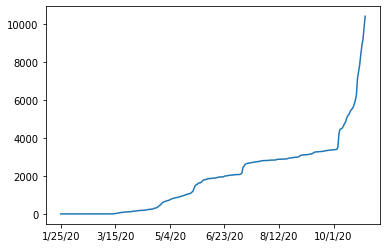

In [ ]:
confirmed_df_LK.plot()

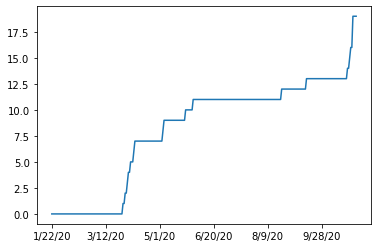

In [ ]:
deaths_df_LK.plot()

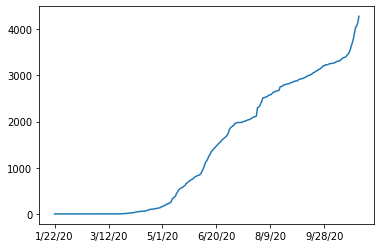

In [ ]:
recovered_df_LK.plot()

In [9]:
from pathlib import Path
import os
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

In [10]:
# Susceptible equation
def dS_dt(S, I, R_t, t_inf):
    return -(R_t / t_inf) * I * S


# Exposed equation
def dE_dt(S, E, I, R_t, t_inf, t_inc):
    return (R_t / t_inf) * I * S - (E / t_inc)


# Infected equation
def dI_dt(I, E, t_inc, t_inf):
    return (E / t_inc) - (I / t_inf)


# Hospialized equation
def dH_dt(I, C, H, t_inf, t_hosp, t_crit, m_a, f_a):
    return ((1 - m_a) * (I / t_inf)) + ((1 - f_a) * C / t_crit) - (H / t_hosp)


# Critical equation
def dC_dt(H, C, t_hosp, t_crit, c_a):
    return (c_a * H / t_hosp) - (C / t_crit)


# Recovered equation
def dR_dt(I, H, t_inf, t_hosp, m_a, c_a):
    return (m_a * I / t_inf) + (1 - c_a) * (H / t_hosp)


# Deaths equation
def dD_dt(C, t_crit, f_a):
    return f_a * C / t_crit


def SEIR_HCD_model(t, y, R_t, t_inc=2.9, t_inf=5.2, t_hosp=4, t_crit=14, m_a=0.8, c_a=0.1, f_a=0.3):
    """

    :param t: Time step for solve_ivp
    :param y: Previous solution or initial values
    :param R_t: Reproduction number
    :param t_inc: Average incubation period. Default 5.2 days
    :param t_inf: Average infectious period. Default 2.9 days
    :param t_hosp: Average time a patient is in hospital before either recovering or becoming critical. Default 4 days
    :param t_crit: Average time a patient is in a critical state (either recover or die). Default 14 days
    :param m_a: Fraction of infections that are asymptomatic or mild. Default 0.8
    :param c_a: Fraction of severe cases that turn critical. Default 0.1
    :param f_a: Fraction of critical cases that are fatal. Default 0.3
    :return:
    """
    if callable(R_t):
        reprod = R_t(t)
    else:
        reprod = R_t
        
    S, E, I, R, H, C, D = y
    
    S_out = dS_dt(S, I, reprod, t_inf)
    E_out = dE_dt(S, E, I, reprod, t_inf, t_inc)
    I_out = dI_dt(I, E, t_inc, t_inf)
    R_out = dR_dt(I, H, t_inf, t_hosp, m_a, c_a)
    H_out = dH_dt(I, C, H, t_inf, t_hosp, t_crit, m_a, f_a)
    C_out = dC_dt(H, C, t_hosp, t_crit, c_a)
    D_out = dD_dt(C, t_crit, f_a)
    return [S_out, E_out, I_out, R_out, H_out, C_out, D_out]

In [11]:
def plot_model(solution, title='SEIR+HCD model'):
    sus, exp, inf, rec, hosp, crit, death = solution.y
    
    cases = inf + rec + hosp + crit + death

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    fig.suptitle(title)
    
    ax1.plot(sus, 'tab:blue', label='Susceptible');
    ax1.plot(exp, 'tab:orange', label='Exposed');
    ax1.plot(inf, 'tab:red', label='Infected');
    ax1.plot(rec, 'tab:green', label='Recovered');
    ax1.plot(hosp, 'tab:purple', label='Hospitalised');
    ax1.plot(crit, 'tab:brown', label='Critical');
    ax1.plot(death, 'tab:cyan', label='Deceased');
    
    ax1.set_xlabel("Days", fontsize=10);
    ax1.set_ylabel("Fraction of population", fontsize=10);
    ax1.legend(loc='best');
    
    ax2.plot(cases, 'tab:red', label='Cases');    
    ax2.set_xlabel("Days", fontsize=10);
    ax2.set_ylabel("Fraction of population (Cases)", fontsize=10, color='tab:red');
    
    ax3 = ax2.twinx()
    ax3.plot(death, 'tab:cyan', label='Deceased');    
    ax3.set_xlabel("Days", fontsize=10);
    ax3.set_ylabel("Fraction of population (Fatalities)", fontsize=10, color='tab:cyan');


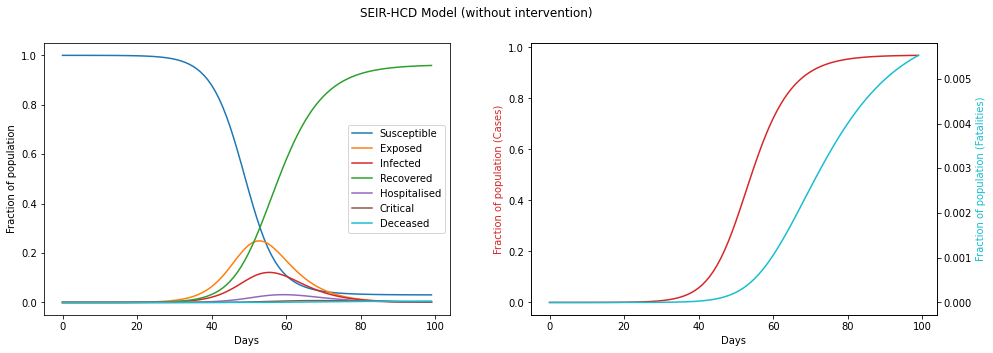

In [12]:
N = 100000  # Population size
n_infected = 1
max_days = 100

# State at time = 0 for SEIR_HCD model
# The numbers correspond to the number of people in each of the SEIRHCD compartments
initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0, 0, 0, 0]

R_0 = 3.6
t_inc = 5.6
t_inf = 2.9
t_hosp = 4
t_crit = 14
m_a = 0.8
c_a = 0.1
f_a = 0.3

args = (R_0, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)

sol = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(max_days))

plot_model(sol, 'SEIR-HCD Model (without intervention)')

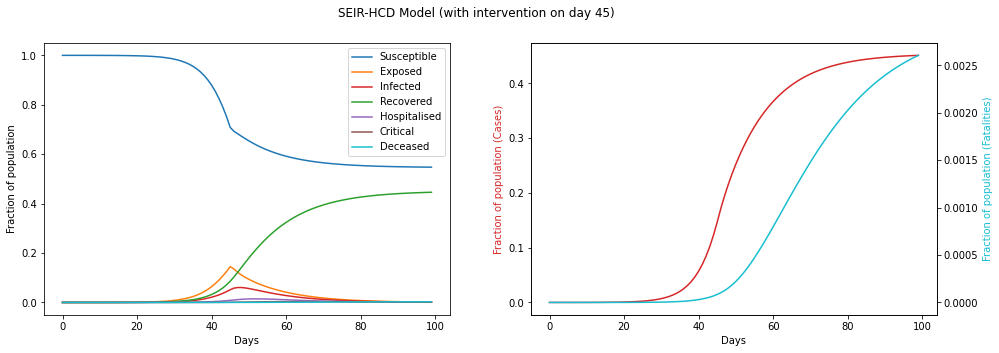

In [13]:
R_0 = 3.6 # reproduction number without intervention
R_t = 0.7  # reproduction number after intervention
intervention_day = 45

def time_varying_reproduction(t):
    if t > intervention_day:
        return R_t
    else:
        return R_0
    
args = (time_varying_reproduction, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)

sol2 = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(max_days))

plot_model(sol2, f'SEIR-HCD Model (with intervention on day {intervention_day})')
OPTIM_DAYS = 21

In [15]:
DATE_BORDER = '2020-11-01'
test_excel = pd.read_excel('/content/test.xlsx')
test = test_excel.to_csv ('test.csv', index = None, header=True)
test = pd.read_csv('/content/test.csv')
test['Date'] = pd.to_datetime(test.Date)
#print(test.head())
submission_excel = pd.read_excel('/content/Submission.xlsx')
submission = submission_excel.to_csv ('submission.csv', index = None, header=True)
submission = pd.read_csv('/content/submission.csv', index_col=['ForecastId'])
submission.head()


,ConfirmedCases,Deaths
ForecastId,,
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1


In [17]:
train_full = merge_train.copy()
print(train_full)
#df['DOB'] = pd.to_datetime(df.DOB)
train_full['Date'] = pd.to_datetime(train_full.Date)
print(train_full)
valid = train_full[train_full['Date'] > test['Date'].min()]
#print(type(test['Date'].min()))
#print('3/1/20' > '8/26/20')
print(valid)
train = train_full[train_full['Date'] <= test['Date'].min()]
#print(train)

# Split the test into public & private
test_public = test[test['Date'] <= DATE_BORDER]
test_private = test[test['Date'] > DATE_BORDER]

# Use a multi-index for easier slicing
#train_full.set_index(['Area', 'Date'], inplace=True)
#train.set_index(['Area', 'Date'], inplace=True)
#valid.set_index(['Area', 'Date'], inplace=True)
#test_public.set_index(['Area', 'Date'], inplace=True)
#test_private.set_index(['Area', 'Date'], inplace=True)

submission['ConfirmedCases'] = 0
submission['Deaths'] = 0

train_full.shape, train.shape, valid.shape, test_public.shape, test_private.shape, submission.shape

         Date  Confirmed  deaths
0     1/25/20          0       0
1     1/26/20          0       0
2     1/27/20          1       0
3     1/28/20          4       0
4     1/29/20          4       0
..        ...        ...     ...
276  10/27/20     463419   10121
277  10/28/20     486972   10259
278  10/29/20     498354   10305
279  10/30/20     517736   10391
280  10/31/20     531790   10483

[281 rows x 3 columns]
          Date  Confirmed  deaths
0   2020-01-25          0       0
1   2020-01-26          0       0
2   2020-01-27          1       0
3   2020-01-28          4       0
4   2020-01-29          4       0
..         ...        ...     ...
276 2020-10-27     463419   10121
277 2020-10-28     486972   10259
278 2020-10-29     498354   10305
279 2020-10-30     517736   10391
280 2020-10-31     531790   10483

[281 rows x 3 columns]
          Date  Confirmed  deaths
275 2020-10-26     450258   10091
276 2020-10-27     463419   10121
277 2020-10-28     486972   10259
278 2020-10-

((281, 3), (275, 3), (6, 3), (8, 2), (41, 2), (49, 2))

In [18]:
def eval_model_const(params, data, population, return_solution=False, forecast_days=0):
    R_0, t_hosp, t_crit, m, c, f = params
    N = population
    n_infected = data['Confirmed'].iloc[0]
    max_days = len(data) + forecast_days
    initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0, 0, 0, 0]
    args = (R_0, 5.6, 2.9, t_hosp, t_crit, m, c, f)
               
    sol = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(0, max_days))
    
    sus, exp, inf, rec, hosp, crit, deaths = sol.y
    
    y_pred_cases = np.clip(inf + rec + hosp + crit + deaths, 0, np.inf) * population
    y_true_cases = data['Confirmed'].values
    y_pred_fat = np.clip(deaths, 0, np.inf) * population
    y_true_fat = data['deaths'].values
    
    optim_days = min(OPTIM_DAYS, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    
    msle_final = np.mean([msle_cases, msle_fat])
    
    if return_solution:
        return msle_final, sol
    else:
        return msle_final

In [19]:
def eval_model_decay(params, data, population, return_solution=False, forecast_days=0):
    R_0, t_hosp, t_crit, m, c, f, k, L = params  
    N = population
    n_infected = data['Confirmed'].iloc[0]
    #n_infected = confirmed_df_LK.iloc[0]
    max_days = len(data) + forecast_days
    
    # https://github.com/SwissTPH/openmalaria/wiki/ModelDecayFunctions   
    # Hill decay. Initial values: R_0=2.2, k=2, L=50
    def time_varying_reproduction(t): 
        return R_0 / (1 + (t/L)**k)
    
    initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0, 0, 0, 0]
    args = (time_varying_reproduction, 5.6, 2.9, t_hosp, t_crit, m, c, f)
            
    sol = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(0, max_days))
    
    sus, exp, inf, rec, hosp, crit, deaths = sol.y
    
    y_pred_cases = np.clip(inf + rec + hosp + crit + deaths, 0, np.inf) * population
    y_true_cases = data['Confirmed'].values
    #y_true_cases = confirmed_df_LK.values
    y_pred_fat = np.clip(deaths, 0, np.inf) * population
    y_true_fat = data['deaths'].values
    #y_true_fat = deaths_df_LK.values
    
    optim_days = min(OPTIM_DAYS, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    msle_final = np.mean([msle_cases, msle_fat])
    
    if return_solution:
        return msle_final, sol
    else:
        return msle_final

In [20]:
def use_last_value(train_data, valid_data, test_data):
    lv = train_data[['Confirmed', 'deaths']].iloc[-1].values
    lv = train_data.iloc[-1].values

    forecast_ids = test_data['ForecastId']
    submission.loc[forecast_ids, ['ConfirmedCases', 'Deaths']] = lv
    
    if valid_data is not None:
        y_pred_valid = np.ones((len(valid_data), 2)) * lv.reshape(1, 2)
        y_true_valid = valid_data[['Confirmed', 'deaths']]

        msle_cases = mean_squared_log_error(y_true_valid['Confirmed'], y_pred_valid[:, 0])
        msle_fat = mean_squared_log_error(y_true_valid['deaths'], y_pred_valid[:, 1])
        msle_final = np.mean([msle_cases, msle_fat])

        return msle_final

In [21]:
def plot_model_results(y_pred, train_data, valid_data=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    
    ax1.set_title('Confirmed Cases')
    ax2.set_title('Deaths')
    
    train_data['Confirmed'].plot(label='Confirmed Cases (train)', color='g', ax=ax1)
    y_pred.loc[train_data.index, 'Confirmed'].plot(label='Modeled Cases', color='r', ax=ax1)
    ax3 = y_pred['R'].plot(label='Reproduction number', color='c', linestyle='-', secondary_y=True, ax=ax1)
    ax3.set_ylabel("Reproduction number", fontsize=10, color='c');
        
    train_data['deaths'].plot(label='Fatalities (train)', color='g', ax=ax2)
    y_pred.loc[train_data.index, 'deaths'].plot(label='Modeled Fatalities', color='r', ax=ax2)
    
    if valid_data is not None:
        valid_data['Confirmed'].plot(label='Confirmed Cases (valid)', color='g', linestyle=':', ax=ax1)
        valid_data['deaths'].plot(label='Fatalities (valid)', color='g', linestyle=':', ax=ax2)
        y_pred.loc[valid_data.index, 'Confirmed'].plot(label='Modeled Cases (forecast)', color='r', linestyle=':', ax=ax1)
        y_pred.loc[valid_data.index, 'deaths'].plot(label='Modeled Fatalities (forecast)', color='r', linestyle=':', ax=ax2)
    else:
        y_pred.loc[:, 'Confirmed'].plot(label='Modeled Cases (forecast)', color='r', linestyle=':', ax=ax1)
        y_pred.loc[:, 'deaths'].plot(label='Modeled Fatalities (forecast)', color='r', linestyle=':', ax=ax2)
        
    ax1.legend(loc='best')

In [22]:
def fit_model_public(#area_name, 
                     initial_guess=[3.6, 4, 14, 0.8, 0.1, 0.3, 2, 50],
                     bounds=((1, 20), # R bounds
                             (0.5, 10), (2, 20), # transition time param bounds
                             (0.5, 1), (0, 1), (0, 1), (1, 5), (1, 100)), # fraction time param bounds
                     make_plot=True):
        
    train_data = train.query('Confirmed > 0')
    print(train_data)
    valid_data = valid
    #print(valid_data)
    test_data = test_public  
    #print(test_data)
    
    #try:
     #   population = province_lookup[area_name]
    #except KeyError:
      #  population = country_lookup[area_name]
    population = 21000000    
    cases_per_million = train_data['Confirmed'].max() * 10**6 / population
    #print(cases_per_million)
    n_infected = train_data['Confirmed'].iloc[0]
    #print(n_infected)
        
    if cases_per_million < 1:
        return use_last_value(train_data, valid_data, test_data)
                
    res_const = minimize(eval_model_const, initial_guess[:-2], bounds=bounds[:-2],
                         args=(train_data, population, False),
                         method='L-BFGS-B')
    #print(res_const)
    
    res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
                         args=(train_data, population, False),
                         method='L-BFGS-B')
    #print(res_decay)
    
    dates_all = train_data.index.append(test_data.index)
    #print(train_data.index)
    #print(test_data.index)
    #print(dates_all)
    dates_all_new = train_full.index
    dates_val = train_data.index.append(valid_data.index)
    #print(dates_val)
    
    # If using a constant R number is better, use that model
    if res_const.fun < res_decay.fun:
        msle, sol = eval_model_const(res_const.x, train_data, population, True, len(test_data))
        res = res_const
        R_t = pd.Series([res_const.x[0]] * len(dates_val), dates_val)
    else:
        msle, sol = eval_model_decay(res_decay.x, train_data, population, True, len(test_data))
        res = res_decay
        
        # Calculate the R_t values
        t = np.arange(len(dates_val))
        R_0, t_hosp, t_crit, m, c, f, k, L = res.x  
        R_t = pd.Series(R_0 / (1 + (t/L)**k), dates_val)
        
    sus, exp, inf, rec, hosp, crit, deaths = sol.y
    #print(sol.y)
    
    y_pred = pd.DataFrame({
        'Confirmed': np.clip(inf + rec + hosp + crit + deaths, 0, np.inf) * population,
        'deaths': np.clip(deaths, 0, np.inf) * population,
        'R': R_t,
    }, index=dates_all_new)

    #print(y_pred)
    
    y_pred_valid = y_pred.iloc[len(train_data): len(train_data)+len(valid_data)]
    #print(y_pred_valid)
    y_pred_test = y_pred.iloc[len(train_data):]
    #print(y_pred_test)
    y_true_valid = valid_data[['Confirmed', 'deaths']]
    #print(y_true_valid)
        
    valid_msle_cases = mean_squared_log_error(y_true_valid['Confirmed'], y_pred_valid['Confirmed'])
    #print(valid_msle_cases)
    valid_msle_fat = mean_squared_log_error(y_true_valid['deaths'], y_pred_valid['deaths'])
    valid_msle = np.mean([valid_msle_cases, valid_msle_fat])
    #print(valid_msle)
    if make_plot:
        print(f'Validation MSLE: {valid_msle:0.5f}')
        print(f'R: {res.x[0]:0.3f}, t_hosp: {res.x[1]:0.3f}, t_crit: {res.x[2]:0.3f}, '
              f'm: {res.x[3]:0.3f}, c: {res.x[4]:0.3f}, f: {res.x[5]:0.3f}')
        plot_model_results(y_pred, train_data, valid_data)
        
    # Put the forecast in the submission
    forecast_ids = test_data['ForecastId']
    #print(forecast_ids)
    submission.loc[forecast_ids, ['ConfirmedCases', 'Deaths']] = y_pred_test[['Confirmed', 'deaths']].values
    
    return valid_msle

In [23]:
def fit_model_private(#area_name, 
                      initial_guess=[3.6, 4, 14, 0.8, 0.1, 0.3, 2, 50],
                      bounds=((1, 20), # R bounds
                              (0.5, 10), (2, 20), # transition time param bounds
                              (0.5, 1), (0, 1), (0, 1), (1, 5), (1, 100)), # fraction time param bounds
                      make_plot=True):
        
    train_data = train_full.query('Confirmed > 0')
    test_data = test_private
    
    #try:
     #   population = province_lookup[area_name]
    #except KeyError:
     #   population = country_lookup[area_name]
    population = 21000000    
    cases_per_million = train_data['Confirmed'].max() * 10**6 / population
    n_infected = train_data['Confirmed'].iloc[0]
        
    if cases_per_million < 1:
        return use_last_value(train_data, None, test_data)
                
    res_const = minimize(eval_model_const, initial_guess[:-2], bounds=bounds[:-2],
                         args=(train_data, population, False),
                         method='L-BFGS-B')
    
    res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
                         args=(train_data, population, False),
                         method='L-BFGS-B')
    
    dates_all = train_data.index.append(test_data.index)
    dates_all_new= train_full.index
    
    # If using a constant R number is better, use that model
    if res_const.fun < res_decay.fun:
        msle, sol = eval_model_const(res_const.x, train_data, population, True, len(test_data))
        res = res_const
        R_t = pd.Series([res_const.x[0]] * len(dates_all), dates_all)
    else:
        msle, sol = eval_model_decay(res_decay.x, train_data, population, True, len(test_data))
        res = res_decay
        
        # Calculate the R_t values
        t = np.arange(len(dates_all))
        R_0, t_hosp, t_crit, m, c, f, k, L = res.x  
        R_t = pd.Series(R_0 / (1 + (t/L)**k), dates_all)
        
    sus, exp, inf, rec, hosp, crit, deaths = sol.y
    
    y_pred = pd.DataFrame({
        'Confirmed': np.clip(inf + rec + hosp + crit + deaths, 0, np.inf) * population,
        'deaths': np.clip(deaths, 0, np.inf) * population,
        'R': R_t,
    }, index=dates_all)
    
    y_pred_test = y_pred.iloc[len(train_data):]
    print(y_pred)
    print(train_data)
    if make_plot:
        print(f'R: {res.x[0]:0.3f}, t_hosp: {res.x[1]:0.3f}, t_crit: {res.x[2]:0.3f}, '
              f'm: {res.x[3]:0.3f}, c: {res.x[4]:0.3f}, f: {res.x[5]:0.3f}')
        plot_model_results(y_pred, train_data)
        
    # Put the forecast in the submission
    forecast_ids = test_data['ForecastId']
    submission.loc[forecast_ids, ['ConfirmedCases', 'Deaths']] = y_pred_test[['Confirmed', 'deaths']].values
            

          Date  Confirmed  deaths
2   2020-01-27          1       0
3   2020-01-28          4       0
4   2020-01-29          4       0
5   2020-01-30          4       0
6   2020-01-31          5       0
..         ...        ...     ...
270 2020-10-21     397922    9911
271 2020-10-22     403874    9960
272 2020-10-23     426110   10008
273 2020-10-24     434798   10035
274 2020-10-25     437698   10062

[273 rows x 3 columns]
Validation MSLE: 0.02522
R: 3.916, t_hosp: 4.000, t_crit: 14.000, m: 0.724, c: 0.216, f: 0.361


0.025215768586304574

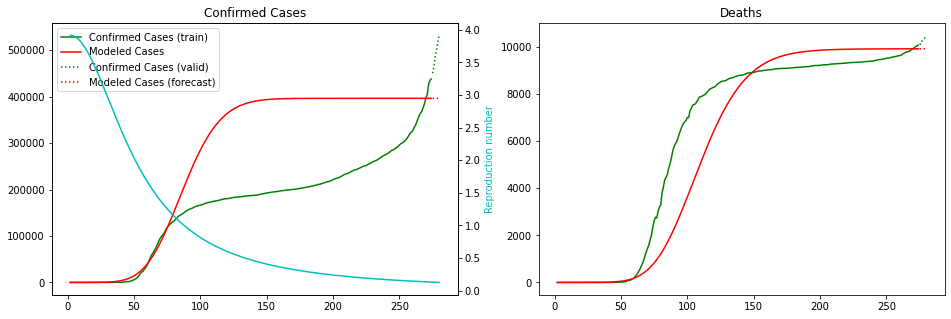

In [24]:
fit_model_public()
#fit_model_private()